In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pathlib
import sys

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 


In [11]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
DATA_PATH = DATA_BASE_PATH / "splited-data"

TRAIN_PATH = DATA_PATH / "train"
TEST_PATH = DATA_PATH / "test"

# set path to repo_dir
os.chdir(REPO_DIR)

## Data

### Variables

In [74]:
RANDOM_SEED = 42
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

VALIDATION_SPLIT = 0.2

BATCH_SIZE = 16


In [75]:
data_df = pd.read_csv(DATA_BASE_PATH / "dogs_df.csv")

breeds_to_include = [
    "Chihuahua",
    "Golden Retriever",
    "Rottweiler",
    "German Shepherd",
    "Beagle",
    "Labrador Retriever",
]

data_df = data_df[data_df["breed"].isin(breeds_to_include)]

data_df

,breed,image_path,annotation_path
1655,Beagle,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1656,Beagle,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1657,Beagle,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1658,Beagle,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1659,Beagle,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
...,...,...,...
15744,Rottweiler,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
15745,Rottweiler,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
15746,Rottweiler,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
15747,Rottweiler,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [76]:
tf.random.set_seed(RANDOM_SEED)

### Data Augmentation

In [77]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale=1./255,
    
    horizontal_flip=True,
    
    rotation_range=30,
    fill_mode="reflect",
    height_shift_range=0.125,       # No need to shift the image
    width_shift_range=0.125,
    zoom_range=0.15,
    
    shear_range=0.1,              # Seems to be useful
    brightness_range=(0.7, 1.3),  # Seems to be useful
    
    validation_split=VALIDATION_SPLIT,
)

val_generator = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    )

test_generator = ImageDataGenerator(
    rescale=1./255,
)

In [78]:
train_images = train_generator.flow_from_dataframe(
    dataframe=data_df,
    x_col="image_path",
    y_col="breed",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='training',
)

val_images = val_generator.flow_from_dataframe(
    dataframe=data_df,
    x_col="image_path",
    y_col="breed",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    
    shuffle=True,
    seed=42,
    
    subset='validation'
)


NUM_TRAIN_IMAGES = len(train_images.filenames)
NUM_VAL_IMAGES = len(val_images.filenames)

Found 778 validated image filenames belonging to 6 classes.
Found 194 validated image filenames belonging to 6 classes.


In [83]:
CLASS_NAMES = list(train_images.class_indices)

### LOADING DATA

In [84]:
from sklearn.preprocessing import LabelEncoder

def give_class_name(y:np.ndarray) -> np.ndarray:
    if len(y.shape) == 2:
        y = y.argmax(axis=1)
    enc = LabelEncoder().fit(CLASS_NAMES)
    y_labeled = enc.inverse_transform(y)
    
    return y_labeled

# display images in a grid function
def display_image_grid(images, labels, pred_val=None,shape=(5, 5), figsize=(10, 10)):
    plt.figure(figsize=figsize)
    m = shape[0] * shape[1]
    
    if images.shape[0] < m:
        raise ValueError("images.shape[0] must equal shape[0] * shape[1]")
    
    if labels.shape[0] != images.shape[0]:
        raise ValueError("labels.shape[0] must equal images.shape[0]")
    
    if pred_val is not None and pred_val.shape[0] != images.shape[0]:
        raise ValueError("pred_val.shape[0] must equal images.shape[0]")
    
    for i in range(m):
        plt.subplot(shape[0], shape[1], i+1)
        plt.imshow(images[i], cmap="gray", interpolation="none")
        title = labels[i]
        if pred_val is not None:
            title = f"{pred_val[i]}"
            if pred_val[i] != labels[i]:
                title += f"\n*({labels[i]})*"
        plt.title(title)
        plt.axis("off")
        # increase vertical space between subplots
        plt.subplots_adjust(wspace=0.1, hspace=0.4)
    plt.show()
    

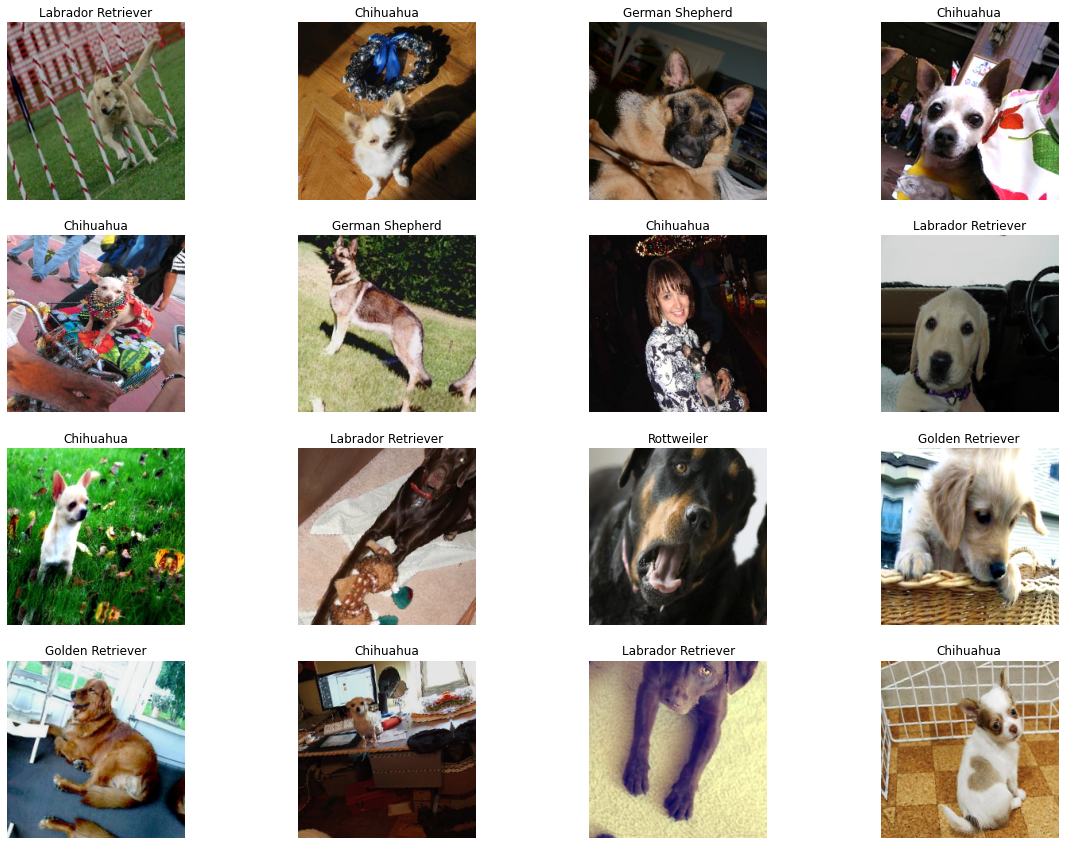

In [86]:
num_rows = 4
num_cols = 4

plt.figure(figsize=(20, 15))

images, labels = train_images.next()
for i in range(num_cols * num_rows):
    plt.subplot(num_cols, num_rows, i + 1)
    plt.imshow(images[i])
    plt.title(CLASS_NAMES[labels[i].argmax()])
    plt.axis('off')

plt.show()

## Model

In [87]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Rescaling, Input, Add, Activation, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, log_loss


### Valribles

In [88]:
INPUT_SHAPE = train_images.next()[0][0].shape
TRAIN_MODELS = True
TRAIN_MODELS = False


### Useful functions ###

In [89]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

def predict_label(images, model):
    predictions = model.predict(images)
    return predictions.argmax(axis=1)


# ploting the model training history
def plot_model_performance(history, figsize=(10, 10)):
    preformance = {key: val for key, val in history.history.items() if "loss" not in key}
    losses = {key: val for key, val in history.history.items() if "loss" in key}
    
    plt.figure(figsize=figsize)
    plt.title('Model Performance')
    for key, val in preformance.items():
        plt.plot(val, label=key)
    plt.legend(preformance.keys())
    plt.xlabel('Epoch')
    
    plt.figure(figsize=figsize)
    plt.title('Model Losses')
    for key, val in losses.items():
        plt.plot(val, label=key)
    plt.legend(losses.keys())
    plt.xlabel('Epoch')
    
    plt.show()


# def get_model_performance(y_true, y_pred):
#     if len(y_true.shape) == 2:
#         y_true = y_true.argmax(axis=1)
#     if len(y_pred.shape) == 2:
#         y_pred = y_pred.argmax(axis=1)

#     accuracy = accuracy_score(y_true, y_pred)
#     # top_5_accuracy = top_k_categorical_accuracy(y_true, y_pred, k=5)
#     f1_scr = f1_score(y_true, y_pred, average='weighted')
#     precision_scr = precision_score(y_true, y_pred, average='weighted')
#     recall_scr = recall_score(y_true, y_pred, average='weighted')
    
    
#     performance = {
#         "Accuracy": accuracy,
#         # "top-5-accuracy": top_5_accuracy,
#         "F1 Score": f1_scr,
#         "Precision": precision_scr,
#         "Recall": recall_scr
#     }
    
#     return performance
def compute_performance_metrics(y, y_pred, verbose=1):
    # labels = test_images_.y.argmax(axis=1)
    labels = y
    labels_cat = tf.keras.utils.to_categorical(labels, NUM_CLASSES)
    # pred_cat = model.predict(test_images_)
    pred_cat = y_pred
    pred = pred_cat.argmax(axis=1)

    
    performance_metrics = {}
    performance_metrics["accuracy"] = round(accuracy_score(labels, pred), 4)
    performance_metrics["top_5_accuracy"] = round(top_k_categorical_accuracy(labels_cat, pred_cat, k=5).numpy().sum() / len(y), 4)
    performance_metrics["f1_score"] = round(f1_score(labels, pred, average="macro"), 4)
    performance_metrics["precision"] = round(precision_score(labels, pred, average="macro"), 4)
    performance_metrics["recall"] = round(recall_score(labels, pred, average="macro"), 4)
    performance_metrics["loss"] = round(log_loss(labels_cat, pred_cat), 4)
    
    performance_df.loc[model.name] = performance_metrics
    if verbose:
        return performance_df.loc[model.name]

performance_df = pd.DataFrame(columns=["accuracy", "top_5_accuracy", "precision", "recall", "f1_score", "loss"])


### MODELS

#### MODEL ARCHITECTURE

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import applications

weight_decay = 25e-6
LEARNING_RATE = 4e-4
learning_rate_decay_rate = 0.08

def create_model(model_backbone: str, model_name:str=None, layers=[256]):
    model_name = model_name or model_backbone
    model = Sequential(name=model_name)
    
    model_backbone = get_model_backbone(model_backbone)
    model_backbone.trainable = False
    model.add(model_backbone)
    model.add(GlobalAveragePooling2D())
    
    model.add(Dropout(0.25))
    
    for layer_size in layers:
        model.add(Dense(layer_size, kernel_regularizer=l2(weight_decay)))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(0.4))
    
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

def get_model_backbone(model_backbone: str):
    if model_backbone == "VGG16":
        model_backbone = applications.VGG16(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "VGG19":
        model_backbone = applications.VGG19(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet18":
        model_backbone = applications.ResNet18(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet50V2":
        model_backbone = applications.ResNet50V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet101V2":
        model_backbone = applications.ResNet101V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "ResNet152V2":
        model_backbone = applications.ResNet152V2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionV3":
        model_backbone = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "InceptionResNetV2":
        model_backbone = applications.InceptionResNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "Xception":
        model_backbone = applications.Xception(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet121":
        model_backbone = applications.DenseNet121(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet169":
        model_backbone = applications.DenseNet169(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "DenseNet201":
        model_backbone = applications.DenseNet201(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNet":
        model_backbone = applications.MobileNet(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
    elif model_backbone == "MobileNetV2":
        model_backbone = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE)
        
    return model_backbone

#### Model Training

In [91]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, CSVLogger


monitor_metric = 'val_accuracy'
# learning_rate_decay_rate = 0.06
def get_callbacks():
    callbacks = {}
    
    callbacks["EarlyStopping"] = EarlyStopping(
            monitor=monitor_metric,
            patience=5,
            mode = "auto",
            verbose=1,
        )
    
    callbacks["LearningRateScheduler"] = LearningRateScheduler(step_decay)

    # callbacks["ModelCheckpoint"] = ModelCheckpoint(
    #         MODEL_PATH / f"{model.name}.h5",
    #         monitor=monitor_metric,
    #         save_best_only=True,
    #         mode='auto',
    #         verbose=1,
    # )
    
    return callbacks


def step_decay(epoch):
    initial_lr = LEARNING_RATE
    k = learning_rate_decay_rate
    lr = initial_lr * np.exp(-k*epoch)
    return lr
NUM_CLASSES = len(breeds_to_include)


In [92]:
backbone_model = "ResNet50V2"
model = create_model(backbone_model, layers=[256])
# LEARNING_RATE = 4e-5
# learning_rate_decay_rate = 0.07

callbacks = [callback for callback in get_callbacks().values()]

model.compile(
        optimizer=Adam(
            learning_rate=LEARNING_RATE
            ), 
        loss='categorical_crossentropy', 
        metrics=[
            'accuracy',
            ]
        )
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_4   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 256)               0

In [94]:
from tensorflow.keras.models import load_model


history = model.fit(train_images, 
                    validation_data=val_images,
                    epochs=50, 
                    callbacks=callbacks,                        
    )

Epoch 1/50
49/49 [==============================] - 11s 193ms/step - loss: 0.8292 - accuracy: 0.7121 - val_loss: 3.4969 - val_accuracy: 0.0000e+00 - lr: 4.0000e-04
Epoch 2/50
49/49 [==============================] - 9s 192ms/step - loss: 0.3212 - accuracy: 0.8985 - val_loss: 4.1061 - val_accuracy: 0.0000e+00 - lr: 3.6925e-04
Epoch 3/50
49/49 [==============================] - 10s 199ms/step - loss: 0.2426 - accuracy: 0.9293 - val_loss: 4.4035 - val_accuracy: 0.0000e+00 - lr: 3.4086e-04
Epoch 4/50
49/49 [==============================] - 10s 194ms/step - loss: 0.2519 - accuracy: 0.9229 - val_loss: 4.4456 - val_accuracy: 0.0000e+00 - lr: 3.1465e-04
Epoch 5/50
49/49 [==============================] - 10s 192ms/step - loss: 0.2421 - accuracy: 0.9267 - val_loss: 4.3985 - val_accuracy: 0.0000e+00 - lr: 2.9046e-04
Epoch 6/50
49/49 [==============================] - 10s 205ms/step - loss: 0.2054 - accuracy: 0.9332 - val_loss: 4.4541 - val_accuracy: 0.0000e+00 - lr: 2.6813e-04
Epoch 6: early st

13/13 [==============================] - 3s 152ms/step - loss: 2.2438 - accuracy: 0.0309


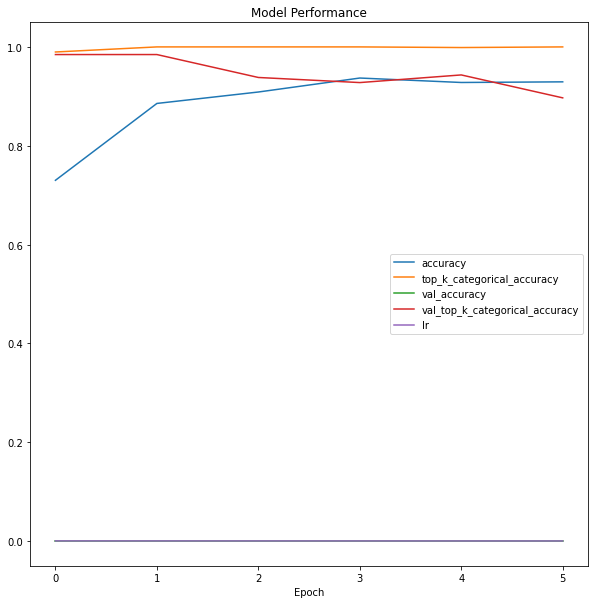

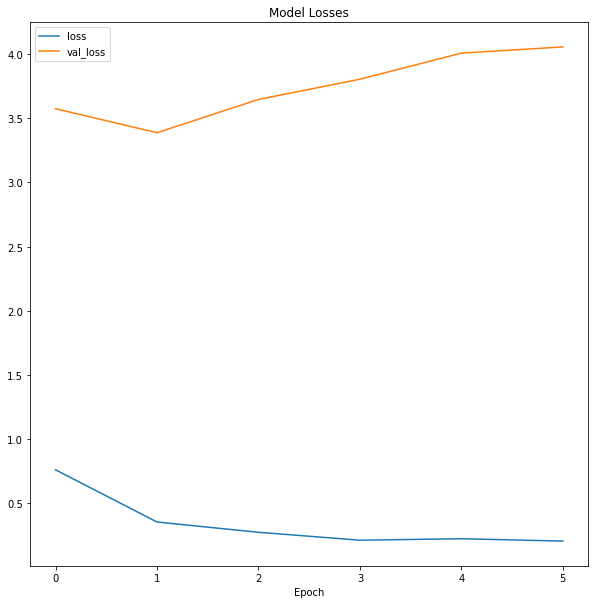

In [93]:
model.evaluate(val_images)
plot_model_performance(history)

In [44]:
test_labels = val_images.labels
test_labels_pred_ohe = model.predict(val_images)
test_labels_pred = test_labels_pred_ohe.argmax(axis=1)
compute_performance_metrics(test_labels, test_labels_pred_ohe, verbose=1)

/home/vineet/miniforge3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


accuracy          0.2048
top_5_accuracy    0.4805
precision         0.1999
recall            0.1972
f1_score          0.1719
loss              3.4398
Name: VGG16, dtype: float64